## **DSTEP20 // Interactive plotting basics**
<small> February 3, 2020 </small>

This notebook will provide an example of visualizations in a web-based interactive visualization libraries.


---

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# -- import bokeh utils
import bokeh.plotting as bp
from bokeh.io import output_notebook

# -- set bokeh to display in the notebook
output_notebook()

In [0]:
from google.colab import drive
drive.mount("/content/drive")

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


First let's load some data and make sample plots using matplotlib.

In [0]:
# -- load the Minneapolis police stops data
fname = "https://opendata.arcgis.com/datasets/215b4b543d894750aef86c725b56ee2a_0.csv"

# -- load the data
stops = pd.read_csv(fname, parse_dates=["responseDate"], low_memory=False)

# -- set response date to date (as opposed to date and time)
stops["responseDate"] = pd.to_datetime(stops["responseDate"].dt.date)

# -- make a time series of all stops
stops_ts = stops.groupby("responseDate").count()["OBJECTID"].reset_index()

# -- and let's make a count by race and year for 2018 and 2019
stops_1819 = stops[(stops.responseDate >= "2018-01-01") & (stops.responseDate < "2020-01-01")]
stops_ry = stops_1819.groupby([stops_1819.responseDate.dt.year, "race"]).count()
stops_ry = stops_ry.unstack("responseDate")
stops_ry = stops_ry["OBJECTID"]
stops_ry = stops_ry.reset_index()
stops_ry.columns = ["race", "2018", "2019"]

In [0]:
# -- load the world bank data
fname = "drive/My Drive/Data_Science/dstep20/data/world_bank/world_bank_gdp_leb.csv"
wb = pd.read_csv(fname)
wb["lpop"] = np.log10(wb["pop2017"])

## **Matplotlib**

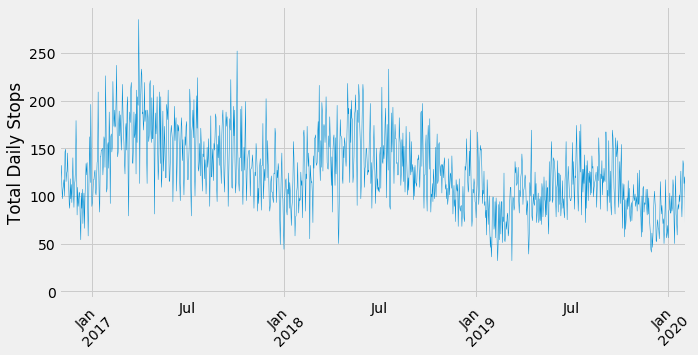

In [0]:
plt.style.use("fivethirtyeight")

# -- basic matplotlib plot
ax = stops_ts.plot("responseDate", "OBJECTID", lw=0.5, legend=False, figsize=[10, 5])
xlab = ax.set_xlabel("")
ylab = ax.set_ylabel("Total Daily Stops")
ax.tick_params(axis="x", rotation=45)

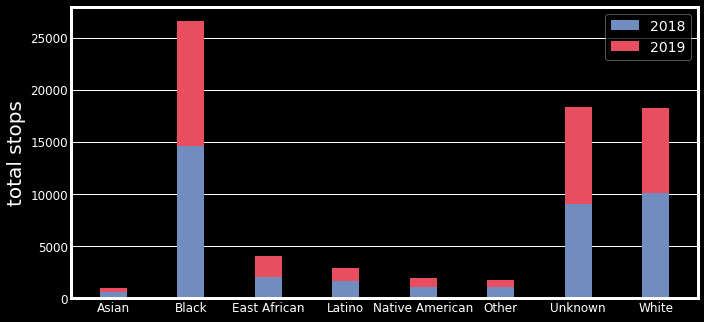

In [0]:
plt.style.use("dark_background")

fig, ax = plt.subplots(figsize=[10, 5])

bars18 = ax.bar(stops_ry.index, stops_ry["2018"], width=0.35, color="#718dbf", label="2018")
bars19 = ax.bar(stops_ry.index, stops_ry["2019"], bottom=stops_ry["2018"], width=0.35, color="#e84d60", label="2019")
ax.grid(axis="x")
ax.set_xticks(stops_ry.index)
ax.set_xticklabels(stops_ry["race"])
ax.legend(fontsize=14)
ax.tick_params(labelsize=12)
ylab = ax.set_ylabel("total stops", fontsize=20)

Text(0, 0.5, 'log(Population)')

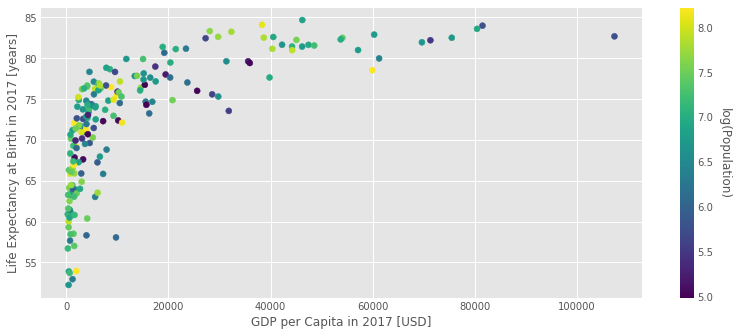

In [0]:
plt.style.use("ggplot")

fig, ax = plt.subplots(figsize=[12, 5])

lpop = np.log10(wb["pop2017"])
lpop = lpop.clip(lpop.min(), 0.9 * lpop.max())
sct = plt.scatter(wb["gpc2017"], wb["leb2017"], c=lpop, cmap=plt.cm.viridis)
cax = fig.colorbar(sct, ax=ax)

ax.set_xlabel("GDP per Capita in 2017 [USD]")
ax.set_ylabel("Life Expectancy at Birth in 2017 [years]")
cax.ax.set_ylabel("log(Population)", rotation=-90, va="bottom")

## **Bokeh**

### **Line plots**

In [0]:
# -- create a new plot (NOT AN MPL FIGURE!)
bfig = bp.figure(x_axis_type="datetime", y_axis_label="Total Daily Stops", width=800, height=400)

# -- plot a line
bfig.line("responseDate", "OBJECTID", source=stops_ts)

bp.show(bfig)

### **Bar charts**

In [0]:
# -- define colors
colors = ["#718dbf", "#e84d60"]

# -- initialize the figure
bfig = bp.figure(x_range=stops_ry["race"], y_axis_label="Total Stops", width=800, height=400)

bfig.vbar_stack(["2018", "2019"], x="race", width=0.9, color=colors, source=stops_ry,
             legend_label=["2018", "2019"])

# -- set figure attirbutes
bfig.y_range.start = 0
bfig.x_range.range_padding = 0.1
bfig.xgrid.grid_line_color = None
bfig.axis.minor_tick_line_color = None
bfig.outline_line_color = None
bfig.legend.location = "top_right"
bfig.legend.orientation = "horizontal"


bp.show(bfig)

### **Scatter plots**

In [0]:
from bokeh.models import ColorBar, Label
from bokeh.palettes import Viridis
from bokeh.transform import linear_cmap

# -- create the colormap
mapper = linear_cmap(field_name="lpop", palette=Viridis[256], 
                     low=wb["lpop"].min(), high=0.9*wb["lpop"].max())

# -- create the tooltips
tt = [["country", "@country"]]

# -- create a new plot
bfig = bp.figure(x_axis_label="GDP per Capita in 2017 [USD]", 
                 y_axis_label="Life expectancy at birth in 2017 [years]", 
                 width=800, height=400, toolbar_location="below", 
                 tools="pan,wheel_zoom,hover,reset", tooltips=tt, 
                 background_fill_color="lightgray")

# -- plot the points
bfig.scatter("gpc2017", "leb2017", radius=600, color=mapper, source=wb)

# -- add a colorbar
color_bar = ColorBar(color_mapper=mapper["transform"], width=8, location=[0, 0])
bfig.add_layout(color_bar, "right")
clabel = Label(x=0, y=200, angle=270, text="log(Population)", 
               angle_units="deg", x_units="screen", y_units="screen")

bfig.add_layout(clabel, "right")

bp.show(bfig)

Other popular libraries include **Plotly** and **Altair**.